In [1]:
# first we define the simulator and setup a quantum instance
import qiskit
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

In [2]:
# then we setup our ansatz for the wavefunction

from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(2, reps=1)
print(type(ansatz))
print(ansatz)
ansatz.draw(style='mpl')

<class 'qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes'>
     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘


┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘

In [3]:
ansatz = RealAmplitudes(3, reps=1)
from qiskit import QuantumCircuit
qc=QuantumCircuit(3)
qc.compose(ansatz,inplace=True)
print(ansatz)


     ┌──────────┐          ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├──■────■──┤ Ry(θ[3]) ├────────────
     ├──────────┤┌─┴─┐  │  └──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├┤ X ├──┼───────■──────┤ Ry(θ[4]) ├
     ├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤
q_2: ┤ Ry(θ[2]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[5]) ├
     └──────────┘     └───┘   └───┘    └──────────┘


In [4]:
# now we have to define the observable we want the minimum eigenvalue of
from qiskit.opflow import X,Y,Z,I

observable = Z^I

In [5]:
# set-up the vqe algorithm, with an optimizer and wave function
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)

In [6]:
# we could run this for many observables
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999882894015+0j)


In [7]:
# now we have to define the observable we want the minimum eigenvalue of
from qiskit.opflow import X,Y,Z,I,H

observable = Y^I

result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

0j


## Lets try it for the HO, should get eigenvalue 0

In [8]:
import sys
sys.path.append('..')
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

In [9]:
h_b_HO = 0.5*(p*p + m*m*q*q)
h_f_HO = -0.5*m#[bdag,b]

powersof2=[2**n for n in range(1,3)]

HOhams = []
for n in powersof2:
    HOhams.append({'n': n, 'ham': Hamiltonian(h_b_HO, h_f_HO, {m:1, g:1},
                  n, standard_encode)})

In [10]:
for sys in HOhams:
    obsHOHAM = pauli_string_to_op(sys['ham'].pauliStrings)
    result = vqe.compute_minimum_eigenvalue(obsHOHAM)
    #print(result.eigenvalue)
    sys['vqe']=result.eigenvalue
    
    eigSys = np.linalg.eig(np.array(sys['ham'].hamMatrix,dtype=float))
    eigVals = [en.real for en in eigSys[0]]    
    sys['exact']=np.min(np.sort(eigVals))

In [11]:
#ovec=vqe.get_optimal_vector()
#svec=qiskit.quantum_info.Statevector(ovec)
#svec.probabilities_dict()

# this will be deprecated soon

In [23]:
def fill_vqe_dict(h_b,h_f,params,sizes):
    res = []
    for n in sizes:
        res.append({'n': n, 'ham': Hamiltonian(h_b, h_f, params, n, standard_encode)})
        
    for sys in res:
        ham = pauli_string_to_op(sys['ham'].pauliStrings)
        results=[]
        for i in range(100):
            results.append(vqe.compute_minimum_eigenvalue(ham).eigenvalue)
        #print(results)
        sys['vqe']=np.array(results).min()
    
        eigSys = np.linalg.eig(np.array(sys['ham'].hamMatrix,dtype=float))
        eigVals = [en.real for en in eigSys[0]]    
        sys['exact']=np.min(np.sort(eigVals))
        
    return res

In [24]:
def latex_vqe_table(data):
    s=''
    for d in data:
        s+="{} & {:.2e} & {:.2e} \\\\ \n".format(d['n'],d['exact'],d['vqe'].real)
    return s

In [25]:
ho_data=fill_vqe_dict(h_b_HO,h_f_HO,{m:1, g:1},[2**i for i in range(1,6)])
print(latex_vqe_table(ho_data))

2 & 0.00e+00 & 5.34e-10 \\ 
4 & 0.00e+00 & 1.07e-09 \\ 
8 & 0.00e+00 & 4.06e-09 \\ 
16 & 0.00e+00 & 1.13e-08 \\ 
32 & 0.00e+00 & 4.81e-08 \\ 



## AHO

In [26]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

In [27]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**2, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([ 0.12682403,  2.08341082,  3.323419  ,  7.31797807, 32.24817597,
       41.29158918, 81.301581  , 94.30702193])

In [28]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**3, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([2.92568799e-02, 1.70677100e+00, 1.78275273e+00, 4.73407590e+00,
       7.22350860e+00, 1.24381795e+01, 1.84881706e+01, 2.61305422e+01,
       7.21041337e+01, 8.49087650e+01])

In [29]:
hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**4, standard_encode)

np.sort(np.linalg.eig(np.array(hamAHO.hamMatrix,dtype=float))[0])[0:10]

array([1.83029849e-03, 1.68720122e+00, 1.70732190e+00, 4.37401524e+00,
       4.41418952e+00, 7.76596507e+00, 7.94769938e+00, 1.23737466e+01,
       1.55392089e+01, 2.23264623e+01])

In [30]:
ho_data=fill_vqe_dict(h_b_AHO,h_f_AHO, {m:1, g:1},[2**i for i in range(1,6)])
print(latex_vqe_table(ho_data))

2 & 9.38e-01 & 9.38e-01 \\ 
4 & 1.27e-01 & 1.27e-01 \\ 
8 & 2.93e-02 & 2.93e-02 \\ 
16 & 1.83e-03 & 6.02e-02 \\ 
32 & 1.83e-05 & 6.63e-01 \\ 



In [16]:
min(np.linalg.eig(getMatrix(hamAHO.pauliStrings))[0])

(0.0018302984872818303+0j)

In [77]:
from src.qiskit_utilities import *

obsAHOHAM = pauli_string_to_op(hamAHO.pauliStrings)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM,tol=)
print(result.eigenvalue)

(1.660006845212543+0j)


In [105]:
# set-up the vqe algorithm, with an optimizer and wave function
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

hamAHO = Hamiltonian(h_b_AHO, h_f_AHO, {m: 1, g:1},
                    2**5, standard_encode)

obsAHOHAM = pauli_string_to_op(hamAHO.pauliStrings)

In [106]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=100,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)

(13.28733413910288+0j)


In [107]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=5000), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)

(1.425103847732708+0j)


In [114]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=10000,tol=1e-5,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.eigenvalue)

(1.800361810904133+0j)


In [118]:
print(result.optimizer_evals)

None


In [129]:
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=1000,tol=1e-0,disp=True), quantum_instance=qinstance)

result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
print(result.cost_function_evals)
#print(result)

28


In [128]:
data = [] 

for i in range(0,100):
    result = vqe.compute_minimum_eigenvalue(obsAHOHAM)
    data.append(result.eigenvalue.real)

KeyboardInterrupt: 

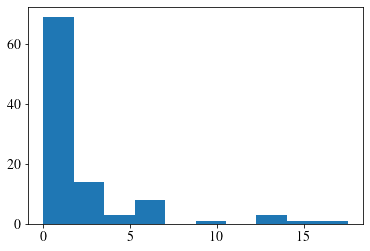

0.01983670266003855


In [73]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data)
plt.show()
print(min(data))

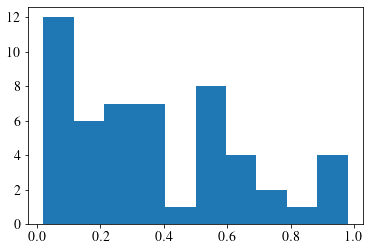

0.01983670266003855


In [74]:
n, bins, patches = plt.hist([i for i in data if i<1.0])
plt.show()
print(min(data))

In [76]:
np.sort(data)[0:10]

array([0.0198367 , 0.03955232, 0.04275566, 0.05550218, 0.06769821,
       0.07642876, 0.08982111, 0.09235218, 0.09681033, 0.10164513])

## DW

In [31]:
h_b_DW = 0.5*(p*p + (m*q + g*(q*q + mu*mu))**2)
h_f_DW = -0.5*(m+2*g*q)#[bdag,b]

In [32]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**2, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([ 0.91503687,  0.95899787,  3.21053807,  3.29031775,  7.00690424,
        7.12497247, 21.36752081, 25.12571192])

In [33]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**3, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([ 0.89308263,  0.89398305,  2.7445775 ,  2.75305657,  4.94585242,
        5.14085855,  8.30667934,  8.70004802, 13.31161275, 14.50467148])

In [34]:
hamDW = Hamiltonian(h_b_DW, h_f_DW, {m: 1, g:1, mu: 1},
                    2**4, standard_encode)

np.sort(np.linalg.eig(np.array(hamDW.hamMatrix,dtype=float))[0])[0:10]

array([0.89163849, 0.8916501 , 2.73421059, 2.73432506, 4.84645895,
       4.84793798, 7.18775479, 7.19586103, 9.75001443, 9.77982411])

In [35]:
dw_data=fill_vqe_dict(h_b_DW,h_f_DW, {m:1, g:1, mu: 1},[2**i for i in range(1,6)])
print(latex_vqe_table(dw_data))

2 & 1.08e+00 & 1.08e+00 \\ 
4 & 9.15e-01 & 9.15e-01 \\ 
8 & 8.93e-01 & 8.93e-01 \\ 
16 & 8.92e-01 & 8.94e-01 \\ 
32 & 8.92e-01 & 8.95e-01 \\ 



In [24]:
min(np.linalg.eig(getMatrix(hamDW.pauliStrings))[0])

(0.9150368745234885+0j)

In [36]:
from src.qiskit_utilities import *

obsDWHAM = pauli_string_to_op(hamDW.pauliStrings)

result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)

(1.0951884052605132+0j)


array([0.89163849, 0.8916501 , 2.73421059, 2.73432506, 4.84645895,
       4.84793798, 7.18775479, 7.19586103, 9.75001443, 9.77982411])

In [57]:
data = [] 

for i in range(0,200):
    result = vqe.compute_minimum_eigenvalue(obsDWHAM)
    data.append(result.eigenvalue.real)

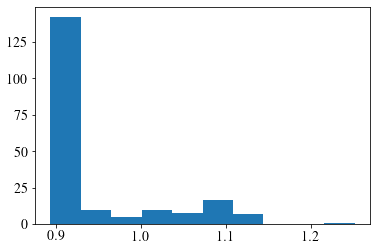

0.8933244311073774


In [58]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data)
plt.show()
print(min(data))

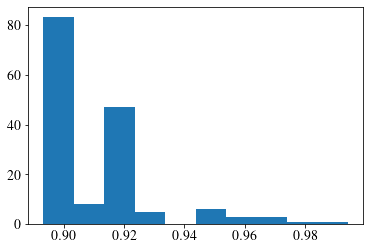

In [60]:
n, bins, patches = plt.hist([i for i in data if i<1.0])
plt.show()

In [26]:
ovec=vqe.get_optimal_vector()

<ipython-input-26-57588e3914d0>:1: DeprecationWarning: 
The VQE.get_optimal_vector method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvector.
  ovec=vqe.get_optimal_vector()


In [27]:
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

{'000': 2.3286164616435062e-07,
 '001': 0.9308631200954977,
 '010': 3.3489621537576535e-09,
 '011': 0.02522975095438438,
 '100': 1.0025483874937313e-08,
 '101': 0.040498411502067,
 '110': 5.983480190999407e-10,
 '111': 0.0034084706136112606}

In [28]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.9150373521469856+0j)


{'000': 8.073637819672949e-07,
 '001': 0.9308282553503109,
 '010': 2.4662794928827658e-08,
 '011': 0.02524028592482414,
 '100': 3.5224547571854214e-08,
 '101': 0.04051712341810499,
 '110': 3.184555735469795e-09,
 '111': 0.003413464871079842}

In [29]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.9150566236540667+0j)


{'000': 6.001019895139936e-06,
 '001': 0.9308511027232788,
 '010': 3.8342875630128493e-07,
 '011': 0.025242013339559208,
 '100': 1.5863500285475468e-07,
 '101': 0.04049166268451669,
 '110': 2.0833487661717596e-07,
 '111': 0.0034084698341147234}

In [30]:
result = vqe.compute_minimum_eigenvalue(obsDWHAM)
print(result.eigenvalue)
ovec=vqe.get_optimal_vector()
svec=qiskit.quantum_info.Statevector(ovec)
svec.probabilities_dict()

(0.958999598759493+0j)


{'000': 0.6831652668751452,
 '001': 1.368271064476127e-06,
 '010': 0.006877669383093812,
 '011': 7.380283086148149e-09,
 '100': 0.3062737829086776,
 '101': 6.60748695841144e-07,
 '110': 0.0036811159798478157,
 '111': 1.284531923240483e-07}

In [31]:
print(vqe.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: 
Qiskit Terra version: 0.18.3
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_probs', 'save_probs_ket', 'save_state', 'save_statevector', 'set_statevector'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': 2, 'optimization_level': None}
RunConfig(shots=1, max_credits=10, seed_simulator=2)
{'timeout': None}
{}
{}
Measur

In [32]:
data = [] 

for i in range(0,200):
    result = vqe.compute_minimum_eigenvalue(obsDWHAM)
    data.append(result.eigenvalue.real)

In [33]:
data

[0.9589996842592351,
 0.9589988550070294,
 0.9150370916020274,
 0.9589989543256704,
 0.9152321873255256,
 0.9589991589509848,
 0.9589982205992242,
 0.9589985314152216,
 0.9150379485320339,
 0.9150397645492373,
 0.9589985749241112,
 0.9158879994116654,
 0.9196171357118081,
 0.9150371928680866,
 0.9150374735974568,
 0.9150371155432887,
 0.958998772041119,
 0.923974233456068,
 0.9590022358243386,
 0.9589989446678718,
 0.9150370486600578,
 0.9593796210321132,
 0.915037165210093,
 0.9150372564778442,
 0.9150372463868378,
 0.9150370163915896,
 0.9589991227268344,
 0.923984548301175,
 0.9150369895711731,
 0.9223103532396554,
 0.915037690589132,
 0.9606013401634718,
 0.9589985323432968,
 0.9589981893331796,
 0.9150371242220745,
 0.9589980926236715,
 0.9621209472673024,
 0.9150369659502577,
 0.9150372312947825,
 0.9177030741769233,
 0.9589982519213868,
 0.9589983816871387,
 0.9150370677977978,
 0.959000926208387,
 0.9150376453154834,
 0.9980125537138819,
 0.9150370964766137,
 0.9179232779207932

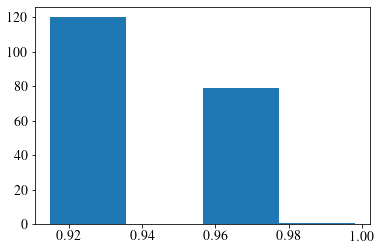

In [34]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(data, 4)
plt.show()